<a href="https://colab.research.google.com/github/Engineer1999/Chest-X-ray-classification-with-GradCAM/blob/main/Chest_X_ray_classification_using_Transfer_Learning_and_GradCAM_for_transparency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import os
import numpy as np
import cv2
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
TrianImage="/content/drive/MyDrive/Osteoporosis Knee X-ray/train"
TestImage="/content/drive/My Drive/Osteoperosis Knee X-ray/val"
Normalimages = os.listdir(TrianImage + "/normal")
Pneumonaimages = os.listdir(TrianImage + "/osteopenia")

In [45]:
print(len(Normalimages), len(Pneumonaimages))
NUM_TRAINING_IMAGES = len(Normalimages) + len(Pneumonaimages)
print(NUM_TRAINING_IMAGES)

28 161
189


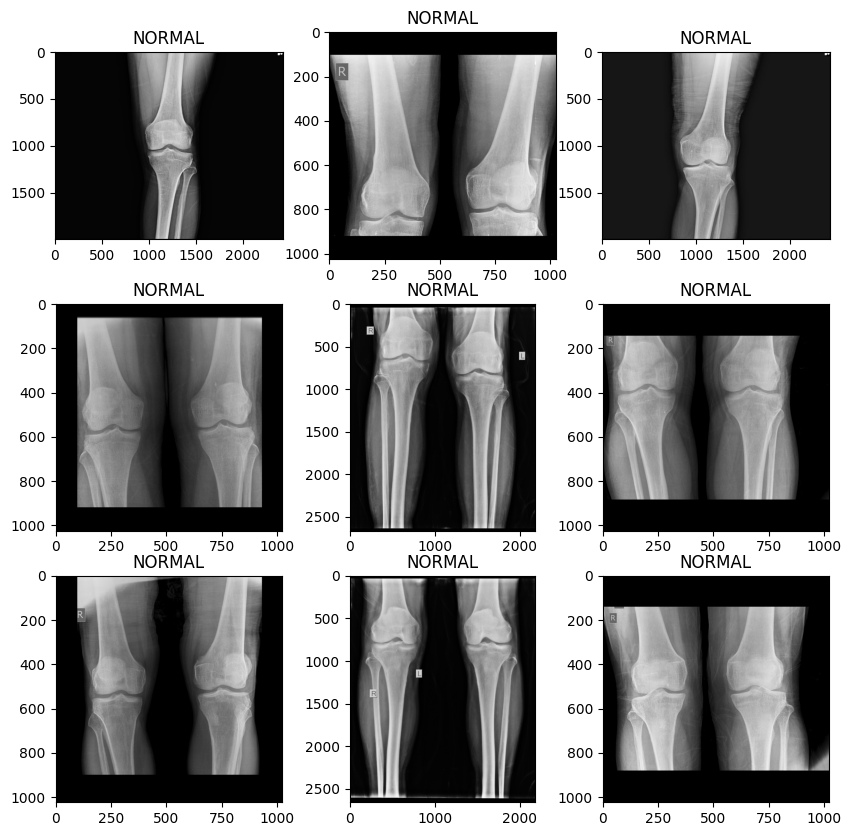

In [46]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/normal",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

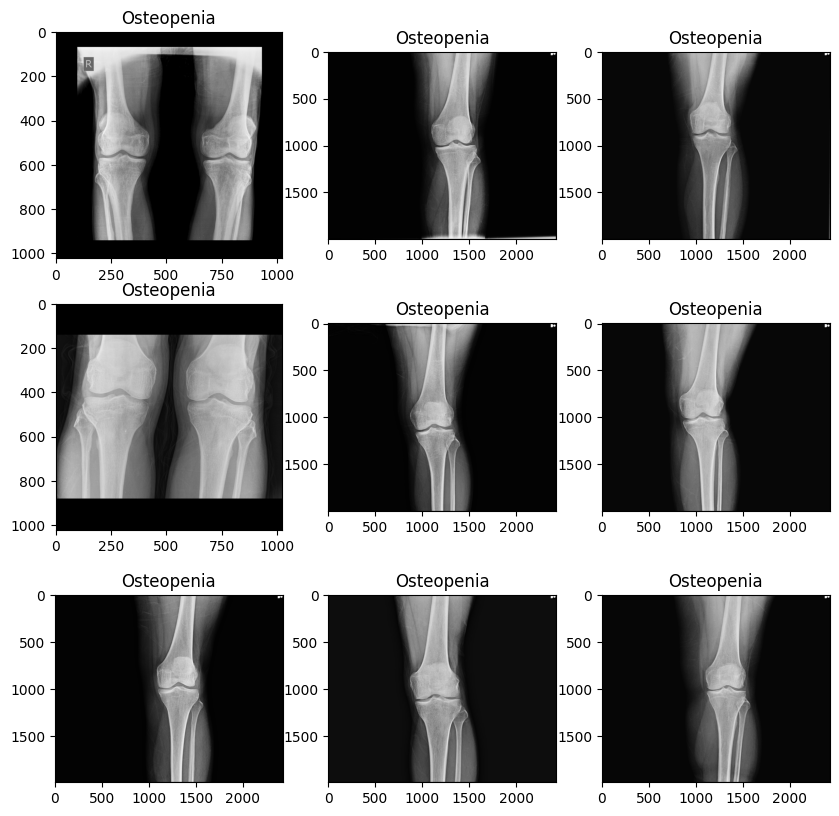

In [47]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/osteopenia",Pneumonaimages[i])),cmap='gray')
    plt.title("Osteopenia")
plt.show()

In [48]:
# https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://medium.com/analytics-vidhya/data-augmentation-is-it-really-necessary-b3cb12ab3c3f

image_size = 224
BATCH_SIZE = 8
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

data_path = '/content/drive/MyDrive/Osteoporosis Knee X-ray'

train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory(data_path + '/val',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 189 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [49]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (8, 224, 224, 3)
test batch  (8, 224, 224, 3)
sample train label 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [50]:
training_set.class_indices

{'normal': 0, 'osteopenia': 1}

In [51]:
testing_set.class_indices

{'normal': 0, 'osetopenia': 1}

In [52]:
testing_set.class_mode

'categorical'

1 [0. 1.]
1 [0. 1.]
1 [0. 1.]
0 [1. 0.]
1 [0. 1.]
1 [0. 1.]
1 [0. 1.]
1 [0. 1.]


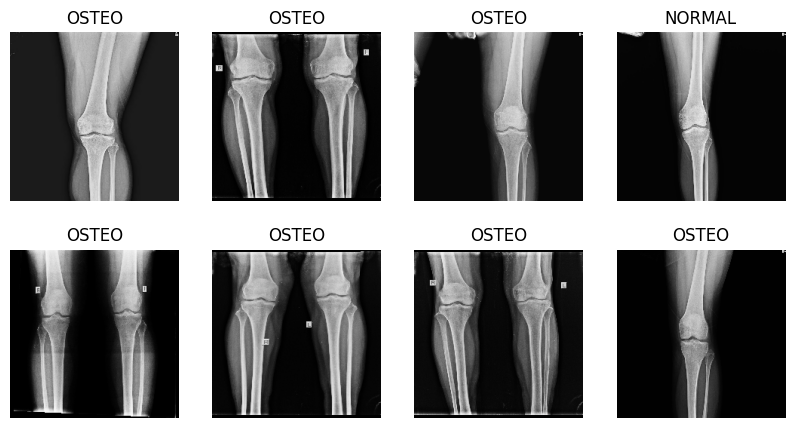

In [111]:
labels = ['NORMAL','OSTEO']

sample_data = testing_set.__getitem__(3)[0]
sample_label = testing_set.__getitem__(3)[1]
plt.figure(figsize=(10,8))
for i in range(8):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    print(np.argmax(sample_label[i]), sample_label[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [112]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [113]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [114]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [115]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [116]:
# training call backs
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [117]:
def create_model():
    pretrained_vgg = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)
    for layer in pretrained_vgg.layers:
        layer.trainable = False
    x3 = pretrained_vgg.output
    x3 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x3)
    x3 = tf.keras.layers.Flatten(name="flatten_head")(x3)
    x3 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x3)
    x3 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x3)
    x3 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2")(x3)
    x3 = tf.keras.layers.Dropout(0.5, name="dropout_head_2")(x3)
    model_out = tf.keras.layers.Dense(2, activation='softmax', name="predictions_head")(x3)

    model_vgg = Model(inputs=pretrained_vgg.input, outputs=model_out)

    return model_vgg

model_vgg = create_model()

model_vgg.summary()

Model: "model_236"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_122 (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0 

In [118]:
model_vgg = create_model()
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),metrics=['accuracy'])

In [119]:
history_vgg = model_vgg.fit(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=30)

Epoch 1/30
24/24 [==============================] - 10s 326ms/step - loss: 0.6913 - accuracy: 0.6825 - val_loss: 0.4955 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 2/30
24/24 [==============================] - 9s 378ms/step - loss: 0.5490 - accuracy: 0.8095 - val_loss: 0.4955 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 3/30
24/24 [==============================] - 9s 360ms/step - loss: 0.5103 - accuracy: 0.8360 - val_loss: 0.5015 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.8466
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
24/24 [==============================] - 7s 299ms/step - loss: 0.5036 - accuracy: 0.8466 - val_loss: 0.4978 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 5/30
24/24 [==============================] - 8s 360ms/step - loss: 0.4972 - accuracy: 0.8254 - val_loss: 0.4957 - val_accuracy: 0.8400 - lr: 5.0000e-05
Epoch 6/30
24/24 [===========================

In [120]:
model_vgg.save('/content/drive/My Drive/Osteoporosis Knee X-ray/vgg_git1.keras')

<ipython-input-112-cf9fe2eb53b1>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


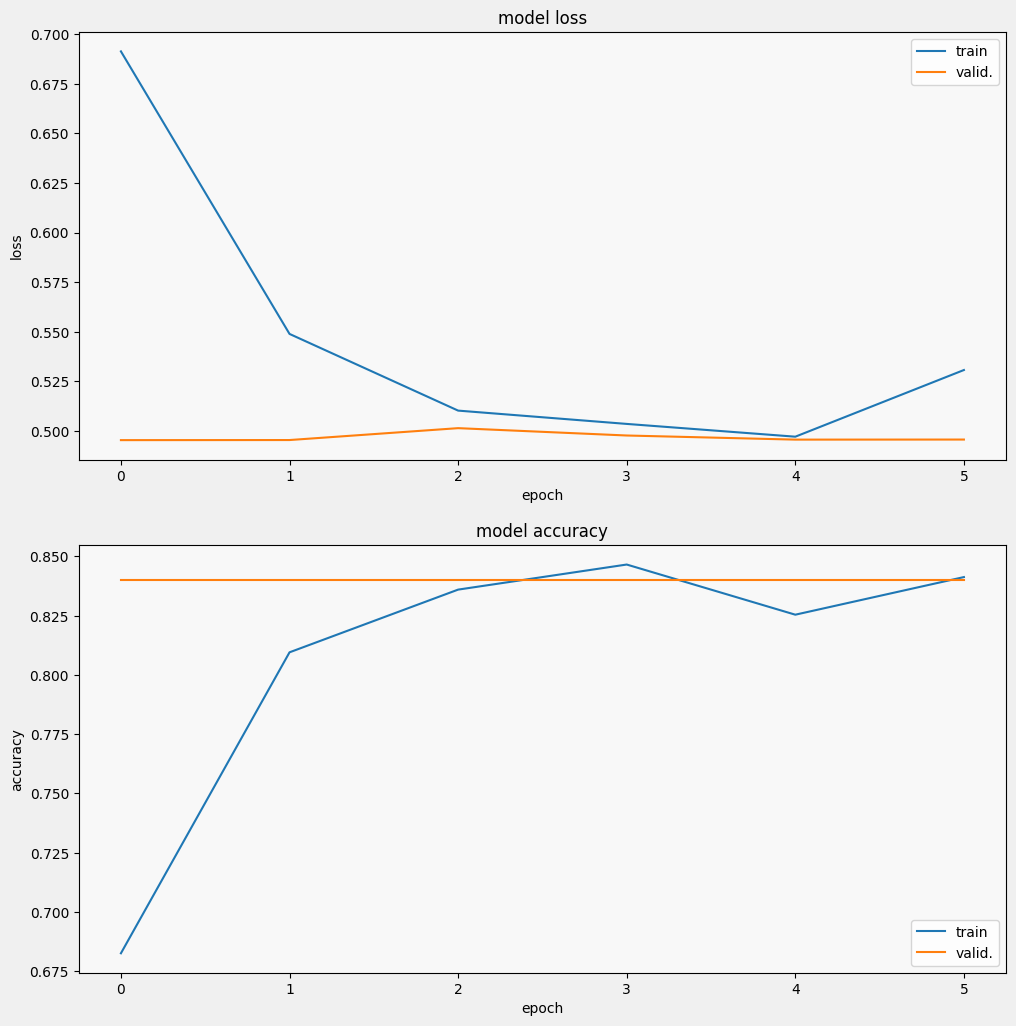

In [121]:
display_training_curves(history_vgg.history['loss'], history_vgg.history['val_loss'], 'loss', 211)
display_training_curves(history_vgg.history['accuracy'], history_vgg.history['val_accuracy'], 'accuracy', 212)

In [122]:
model_vgg_load = tf.keras.models.load_model(('/content/drive/My Drive/Osteoporosis Knee X-ray/vgg_git1.keras'))

In [123]:
out_put = model_vgg_load.predict(np.expand_dims(sample_data[0], axis=0))

1/1 [==============================] - 0s 498ms/step


In [124]:
labels[np.argmax(out_put)]

'OSTEO'

In [125]:
sample_label[0]

array([0., 1.], dtype=float32)

In [126]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "dense_head_2",
    "dropout_head_2",
    "predictions_head"
]

<ipython-input-114-5ea64276194c>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


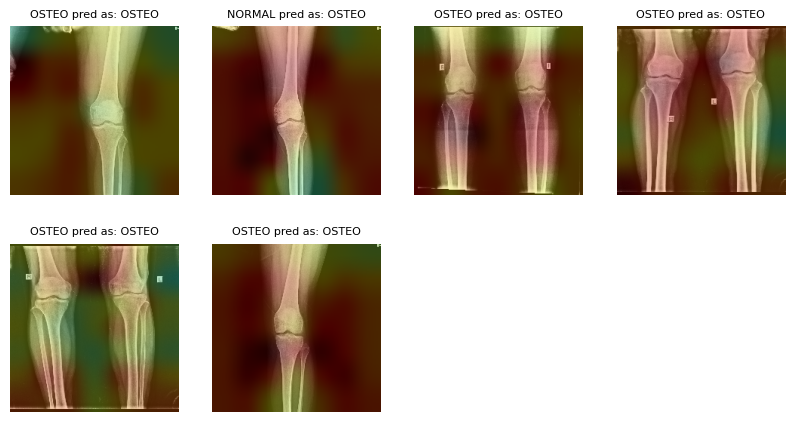

In [127]:
plt.figure(figsize=(10,8))
k=2
for i in range(6):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[k], axis=0), model_vgg_load, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[k])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[k])] + " pred as: " + labels[top_index], fontsize=8)
    k=k+1

In [128]:
model_vgg.save("model_vgg_30_09286.h5")

In [108]:
len(sample_data)

8

In [109]:
len(testing_set)

7

<ipython-input-114-5ea64276194c>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


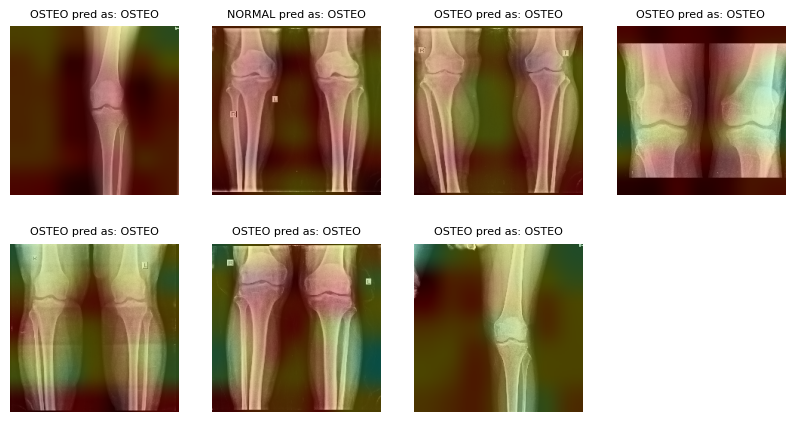

In [131]:
sample_data = training_set.__getitem__(9)[0]
sample_label = training_set.__getitem__(9)[1]
plt.figure(figsize=(10,8))
k=1
for i in range(7):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[k], axis=0), model_vgg_load, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[k])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[k])] + " pred as: " + labels[top_index], fontsize=8)
    k=k+1

Osteo
Osteo
Osteo
Osteo
Osteo
Osteo


<ipython-input-114-5ea64276194c>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo
Osteo


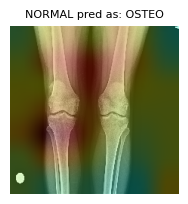

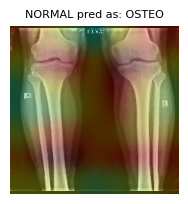

<Figure size 1000x800 with 0 Axes>

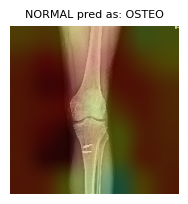

In [138]:
# investing why the missclassification of normal happens so frequently
# how frequently does it happen. Maybe it always classifies as osteoporosis.

for i in range(4): # iterating through each batch we generated and passing only normal class to gradcam to see whats going wrong
  sample_data = testing_set.__getitem__(i)[0]
  sample_label = testing_set.__getitem__(i)[1]
  plt.figure(figsize=(10,8))
  k=0
  for j in range(7):
      # proceed only if the class is normal
      if labels[np.argmax(sample_label[k])] == "NORMAL":
        plt.subplot(3, 4, j + 1)
        plt.axis('off')
        heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[k], axis=0), model_vgg_load, last_conv_layer_name, classifier_layer_names)
        img = np.uint8(255 * sample_data[k])
        s_img = superimposed_img(img, heatmap)
        plt.imshow(s_img)
        plt.title(labels[np.argmax(sample_label[k])] + " pred as: " + labels[top_index], fontsize=8)
      else:
        print("Osteo")
      k=k+1